## Pendulum: One-step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader import *
from loss import *
from utils import *

import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

In [4]:
model = 'pendulum'

### Cost function

Compute `Kphiphi` and its corresponding regularizing matrix `R`

In [5]:
# Create Kphiphi
X = x_train_all.flatten()
sigma_K = jnp.array([0.14840741, 0.88888889, 0.88888889])
Kphiphis = [Kphiphi_assembly( X[i*e:(i+1)*e] , k = 'Gaussian', k_param = sigma_K[i]) for i in range(3)]

In [6]:
Rs = [jnp.diag(jnp.diag(Kphiphis[i])) for i in range(3)]

Create objective function `L`

In [11]:
def L(Z, X, U, f, Kphiphis, Rs, lmbd):
    """Cost function for one step method.
    
    Args:
        Z: Vector of optimization variables in the cost function. 2*m*N
        X: List of mN points of dimension d.
        U: List of mN values of functions u^(1),...u^(N).
        f: List of mN values of functions u^(1),...u^(N).
        R: Matrix that regularizes Kphiphi
    Returns:
        scalar: a cost of this solution.    
    """ 
   
    ### First term

    # Build S_N
    S1 = jnp.vstack([X,U]).T
    S = jnp.hstack([S1,Z])

    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    
    # Gamma(S_N,S_N)
    sigma_Gamma = 0.8152747082066607 # From 2-step 
    Gamma = K(Gaussian, S, S, sigma_Gamma)
    alpha_Gamma = 1e-7 # From 2-step
    Gamma = Gamma + alpha_Gamma*jnp.eye(jnp.size(Gamma,0)) 
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma)) # Condition number of Gamma

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    rkhs_P = 4038.8546192430285 # From 2-step
    L1 = jnp.dot(f.T , b) / rkhs_P
    #print("L1(Z_warm) = ", L1)


    ### Second term

    L2 = 0.

    alpha_K = 1e-6 # Nugget 
    Kphiphis = [Kphiphis[i] + alpha_K*Rs[i] for i in range(3)] 
    #print("cond(Kphiphis) = ", jnp.linalg.cond(Kphiphis)) # Condition number

    rkhss = [1.1833129190245972, 10.115269194432372, 136.2124679543351]
    ZZ = jnp.hstack((U.reshape(-1,1),Z))
    for i in range(3):
        Z_i = jnp.reshape(ZZ[e*i:e*(i+1),:].T,(e*3,1)) # DOUBLE CHECK THE ORDER HERE
        #print('Z_{}'.format(i),Z_i) 
        c = jnp.linalg.solve(Kphiphis[i],Z_i) 
        L2 += jnp.reshape(jnp.dot(Z_i.T , c),())/rkhss[i] # NORMALIZATION MIGHT NOT BE NEEDED HERE IN THE 1.5 STEP METHOD
        #print("L2_{} = ".format(i+1),jnp.reshape(jnp.dot(Z_i.T , c),())/rkhss[i])
    # Compute the total loss per epoch - It's going down !
    # Compute the loss per function u epoch  
    # Compute the total loss normalized per epoch
    # Compute the loss per function u normalized per epoch

    #print("L2(Z_warm) = ",L2)

    return L1 + lmbd*L2 # Return loss.

#### Training data and warm up

Training data

In [12]:
# First column in Gamma(S_N,S_N)
X = x_train_all.flatten() # N*m * 1

# Second column in Gamma(S_N,S_N)
U = u_train.T.reshape(e*m,) # N*m * 1

# f(X_N)
f = f_Train(model)

Initial guess: `Z_warm`

In [13]:
# Load gradients from 2-step
u_x_pred_train  = np.load('data/u_x_pred_train.npy')
u_xx_pred_train = np.load('data/u_xx_pred_train.npy')
# Build Z_warm
Z_warm = np.hstack([u_x_pred_train.T.reshape(e*m,1),u_xx_pred_train.T.reshape(e*m,1)])

In [14]:
L(Z_warm, X, U, f, Kphiphis, Rs, lmbd = 1/3)

Array(1.9999881, dtype=float64)

In [15]:
lmbd_min = 1/3 

Initialize the grad functions with `jit` to be efficient

In [17]:
grad_Z = jit(grad(L, argnums=0))

# Run once to trigger JIT compilation.
grad_Z(Z_warm, X, U, f, Kphiphis, Rs, lmbd= lmbd_min)

Array([[-0.03153047, -0.00708913],
       [-0.07287239, -0.0031152 ],
       [-0.08243508, -0.01732677],
       [-0.13644785, -0.00760032],
       [ 0.01092829,  0.01865299],
       [ 0.36908927,  0.03861299],
       [-0.01584958, -0.00340532],
       [ 0.02673529,  0.01415693],
       [ 0.02252488, -0.00414139]], dtype=float64)

#### Gradient descent

- Scipy LBFGS, JAX has this too. 
- Newton type algorithm.
- Step size: 
- 1.5-step method could be used as a preconditioner for the 1step method.

In [19]:
# Only do this for the first time - 
Z = np.copy(Z_warm)
#Z = np.load('data/Z.npy')

In [27]:
# If trained previously use Z
if np.all(Z != Z_warm):
    Z = np.load('data/Z.npy')
else:
    Z = np.copy(Z_warm)
learning_rate = 1e-4
for i in range(10000):
    delta_Z = grad_Z(Z, X, U, f, Kphiphis, Rs, lmbd=lmbd_min)
    lr = jnp.linalg.norm(Z)/jnp.linalg.norm(delta_Z)*learning_rate
    Z -= lr * delta_Z
    if i % 10 == 0:
        print(L(Z, X, U, f, Kphiphis, Rs, lmbd=lmbd_min))
        # Load true gradients from 2-step
        u_x_train = np.load('data/u_x_train.npy')
        u_xx_train = np.load('data/u_xx_train.npy')
        # Build true Z
        Z_true = np.hstack([u_x_train.T.reshape(e*m,1),u_xx_train.T.reshape(e*m,1)])
               
# Save at the end of iterations
np.save('data/Z.npy',Z)

2.999369923758813
2.999362388259992
2.9993548548421956
2.99934732350327
2.999339794241302
2.9993322670542186
2.9993247419400406
2.9993172188966954
2.9993096979223
2.9993021790146637
2.999294662171804
2.999287147391806
2.9992796346725368
2.9992721240119935
2.9992646154083324
2.9992571088594335
2.999249604363304
2.999242101918059
2.9992346015214806
2.9992271031717026
2.999219606866686
2.9992121126045683
2.999204620383347
2.999197130200965
2.9991896420554944
2.9991821559449
2.9991746718672676
2.9991671898207284
2.9991597098030613
2.9991522318124773
2.9991447558470496
2.9991372819046016
2.9991298099834203
2.9991223400813807
2.9991148721966225
2.999107406327229
2.9990999424711586
2.999092480626609
2.9990850207914486
2.9990775629639073
2.9990701071419443
2.999062653323499
2.9990552015067604
2.999047751689914
2.9990403038708244
2.9990328580477414
2.999025414218582
2.9990179723815977
2.9990105325347174
2.9990030946763095
2.99899565880425
2.9989882249165705
2.9989807930113743
2.998973363086952


#### Evaluation of `Z`

In [50]:
# Load true gradients from 2-step
u_x_train = np.load('data/u_x_train.npy')
u_xx_train = np.load('data/u_xx_train.npy')
# Build true Z
Z_true = np.hstack([u_x_train.T.reshape(e*m,1),u_xx_train.T.reshape(e*m,1)])

> One-step Method vs Truth (GOAL HERE IS P)

- Add a finer grid for these gradients and all the other functions to be tested.
- Add the same square 9x9 plots from the two step method here.

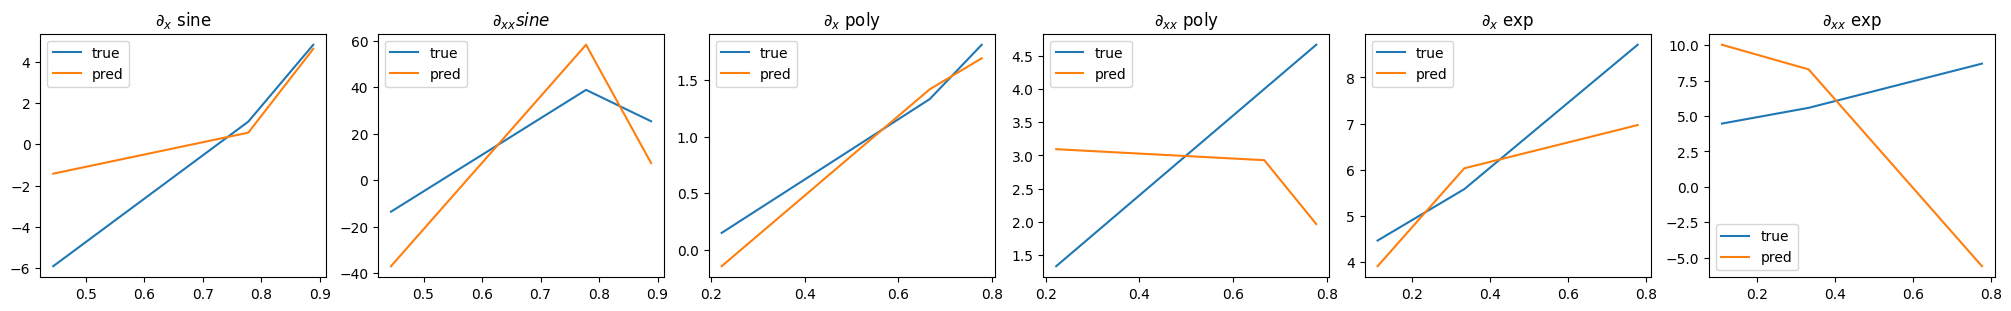

In [23]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train[0:e],Z_true[0:e,0],label ='true')
ax1.plot(x_train[0:e],Z[0:e,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train[0:e],Z_true[0:e,1],label ='true')
ax2.plot(x_train[0:e],Z[0:e,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train[e:2*e],Z_true[e:2*e,0],label ='true')
ax3.plot(x_train[e:2*e],Z[e:2*e,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train[e:2*e],Z_true[e:2*e,1],label ='true')
ax4.plot(x_train[e:2*e],Z[e:2*e,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train[2*e:3*e],Z_true[2*e:3*e,0],label ='true')
ax5.plot(x_train[2*e:3*e],Z[2*e:3*e,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train[2*e:3*e],Z_true[2*e:3*e,1],label ='true')
ax6.plot(x_train[2*e:3*e],Z[2*e:3*e,1],label ='pred')
ax6.legend()
plt.show()

> Two-step Method vs Truth

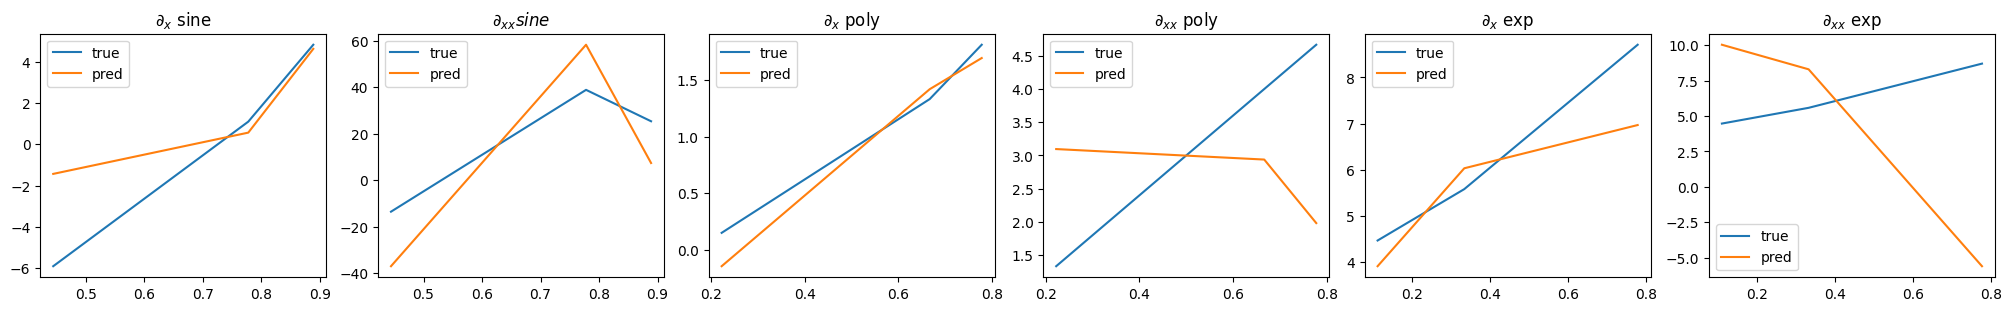

In [24]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train[0:e],Z_true[0:e,0],label ='true')
ax1.plot(x_train[0:e],Z_warm[0:e,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train[0:e],Z_true[0:e,1],label ='true')
ax2.plot(x_train[0:e],Z_warm[0:e,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train[e:2*e],Z_true[e:2*e,0],label ='true')
ax3.plot(x_train[e:2*e],Z_warm[e:2*e,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train[e:2*e],Z_true[e:2*e,1],label ='true')
ax4.plot(x_train[e:2*e],Z_warm[e:2*e,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train[2*e:3*e],Z_true[2*e:3*e,0],label ='true')
ax5.plot(x_train[2*e:3*e],Z_warm[2*e:3*e,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train[2*e:3*e],Z_true[2*e:3*e,1],label ='true')
ax6.plot(x_train[2*e:3*e],Z_warm[2*e:3*e,1],label ='pred')
ax6.legend()
plt.show()

0. Fix everything in the notebook.
1. Optimization algorithms for one step.
2. Get all the information as we optimize, e.g., progress of P^*.
3. Code the 1.5 step method.
4. We should include the constrain of enforcing the PDE for each u_i at the remaining u_i's.